In [225]:
from IPython.display import Audio 
from matplotlib import pyplot as plt
import librosa
import os
import librosa.display as lid
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import random
import numpy as np
import torch
import torchaudio
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import pandas as pd
import cv2
import warnings

C:\Users\Propietario\AppData\Local\Temp\ipykernel_27396\1065638602.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


In [226]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sub = pd.read_csv('SampleSubmission.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [227]:
print(test.shape)
test.head()


(911, 7)


,ID,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,019OYB,NaN,NaN,NaN,NaN,NaN,NaN
1,01S9OX,NaN,NaN,NaN,NaN,NaN,NaN
2,02CS12,NaN,NaN,NaN,NaN,NaN,NaN
3,02LM3W,NaN,NaN,NaN,NaN,NaN,NaN
4,0C3A2V,NaN,NaN,NaN,NaN,NaN,NaN


In [228]:
print(sub.shape)
sub.head()

(911, 41)


,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
# Add file names
train['file_name'] = os.getcwd() + '/Train/Train/'+train['ID']+'.mp3'
test['file_name'] = os.getcwd() + '/Test/Test/'+test['ID']+'.mp3'

#### Utilities

In [230]:
class CFG:

    # Training
    seed=42
    batch_size = 64
    eps = 1e-6

    # audio 
    sample_rate = 32000
    duration = 15
    audio_len = duration * sample_rate

    # melspectogram
    n_fft = 2048
    hop_length = 512
    n_mels = 128
    f_min = 20
    f_max = 16000
    top_db = 80


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
      

def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def read_spectrogram(audio, audio_sr, normalise=False):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=audio_sr, 
                                #    n_mels=CFG.n_mels,
                                #    n_fft=CFG.n_fft,
                                #    hop_length=CFG.hop_length,
                                #    fmax=CFG.f_max,
                                #    fmin=CFG.f_min,
                                   )
                                   
    spec = librosa.power_to_db(spec, top_db=CFG.top_db, 
                               #ref=1.0
                               )
    
    if normalise:
        min_ = spec.min()
        max_ = spec.max()
        if max_ != min_:
            spec = (spec - min_)/(max_ - min_)
    return spec





def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.ID} | Name: {row.common_name}'
    # Read audio file
    audio, sr = load_audio(row.file_name)
    # Keep fixed length audio
    # audio = audio[:CFG.audio_len]

    # audio = pad_short_audio(audio, audio_length=CFG.audio_len)
    audio = duplicate_short_audio(audio, CFG.audio_len)
    
    # Spectrogram from audio
    spec = read_spectrogram(audio, audio_sr=sr)
    print(spec.shape)
    # Display audio
    print("# Audio:")
    display(Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.f_min,
                 fmax=CFG.f_max,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()



# mel_spec parameters
mel_spec_params = {
    'sample_rate': CFG.sample_rate,
    'n_fft': CFG.n_fft,
    'hop_length': CFG.hop_length,
    'f_min': CFG.f_min,
    'f_max': CFG.f_max ,
    'n_mels': CFG.n_mels,
}



# function to extend audio if audio length is shorter by duplicating it
def duplicate_short_audio(audio, audio_length):
    # check if audio is shorter
    while audio.shape[0] < audio_length:
        audio = np.concatenate((audio, audio), axis=0)
    audio = audio[:audio_length]
    return audio

# function to extend audio if audio length is shorter by padding it with zeros 
def pad_short_audio(audio, audio_length):
    if audio.shape[0] < audio_length:
        padded_audio = np.zeros((audio_length, ))
        # copy all available samples of audio into padded audio and leave the rest as zero
        padded_audio[:audio.shape[0]] = audio[:]
        audio = padded_audio
    else:
        audio = audio[:audio_length]
    return audio



# function to convert audio to melspectogram
def audio_to_melspectogram(path):
    # read audio
    audio, sr = load_audio(path)

    len = sr * CFG.duration

    # extend shorter audio with zero
    # audio = pad_short_audio(audio, audio_length=len)

    # extend shorter audio with same audio
    audio = duplicate_short_audio(audio, audio_length=len)

    
    # transforms
    # mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)


    spec_transform = read_spectrogram(audio, sr)
    # apply transformation on audio
    # mel_specgram  = mel_transform(audio)
    # convert power to decibels
    # db_transform = torchaudio.transforms.AmplitudeToDB(top_db=CFG.top_db)
    # apply transformation on spectogram
    # db_melspecgram = db_transform(mel_specgram).to(torch.float32)
    return spec_transform



# function to normalise_ and convert to 3 channels
def spec_to_mono_then_normalise(spectogram):
    # if num_channels equals 1
    # if spectogram.shape[0] == 1:
    #     spectogram = spectogram.repeat(3, 1, 1)
    # # if num_channels equals 2
    # if spectogram.shape[0] == 2:
    #     spectogram = torch.cat([spectogram, spectogram.mean(dim=0, keepdim=True)], dim=0)

    # ensure the spectogram has only one channel for the channel dimension
    # spectogram = spectogram[0:1, ...]
    # if spectogram.shape[0] != 1:
    #     print(f'{spectogram.shape=}')
    #     raise ValueError('Spectogram has more than one channel in channel dimension.')

    # repeat the one channel dimension to create a 3 channel RGB spectogram
    # spectogram = spectogram.repeat(3, 1, 1)
    # if spectogram.shape[0] !=3:
    #     print(f'{spectogram.shape=}')
    #     raise ValueError('Spectogram does not have a RGB channel.')

    # get mean and std
    spec_mean, spec_std = spectogram.mean(), spectogram.std()
    
    # apply Z-score normalisation
    z_norm_spec = (spectogram - spec_mean) / (spec_std + CFG.eps)

    # get minimum and maximum values of normalised spectogram
    min_value, max_value = z_norm_spec.min(), z_norm_spec.max()

    min_max_spec = 255 * (z_norm_spec - min_value) / (max_value - min_value)
    norm_spectogram = min_max_spec.astype(np.uint8)
   
    return norm_spectogram



In [231]:
# seed 
seed_everything(CFG.seed)

In [232]:
audio_filename=train['file_name'].sample(n=1).iloc[0]
demo_audio = audio_to_melspectogram(audio_filename)
print(demo_audio.shape)

demo_norm_audio = spec_to_mono_then_normalise(demo_audio)
print(demo_norm_audio.shape)

(128, 646)
(128, 646)


#### Data Visualisation

In [233]:
np.random.randint(0, train.shape[0])

661

In [234]:
african = train[train['ID']=='VBK6YM']

(128, 938)
# Audio:


# Visualization:


C:\Users\Propietario\AppData\Local\Temp\ipykernel_27396\1396634533.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


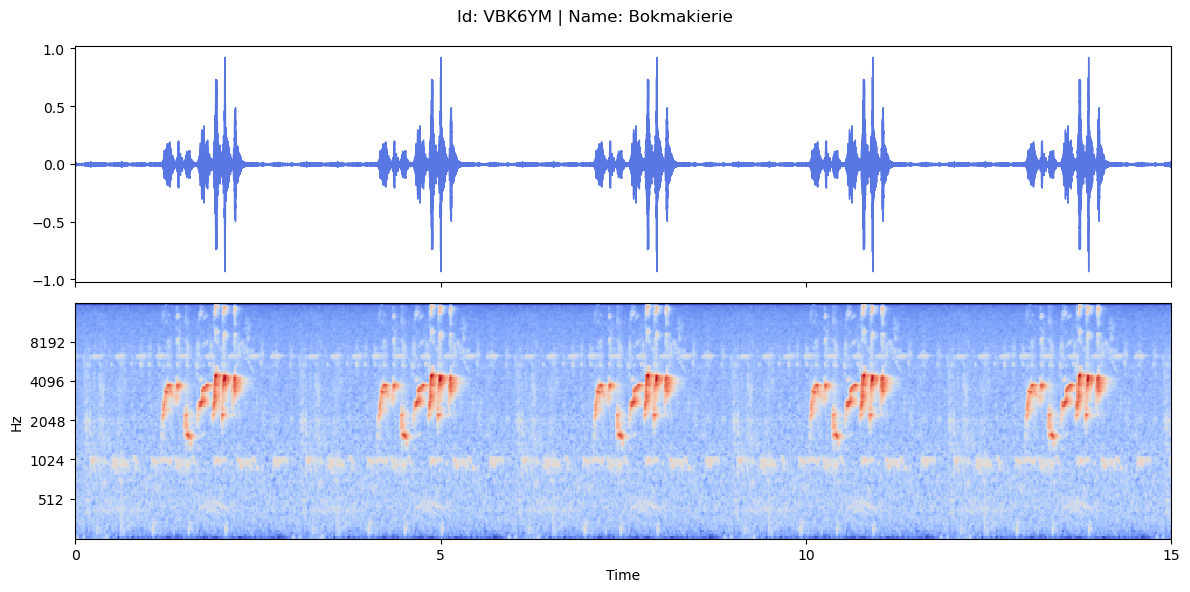

In [235]:
# display a random audio

# random_id = train.iloc[np.random.randint(0, train.shape[0])]
# display_audio(random_id)
display_audio(african.iloc[0])

#### Visualise the Common Birds and least common birds in the dataset

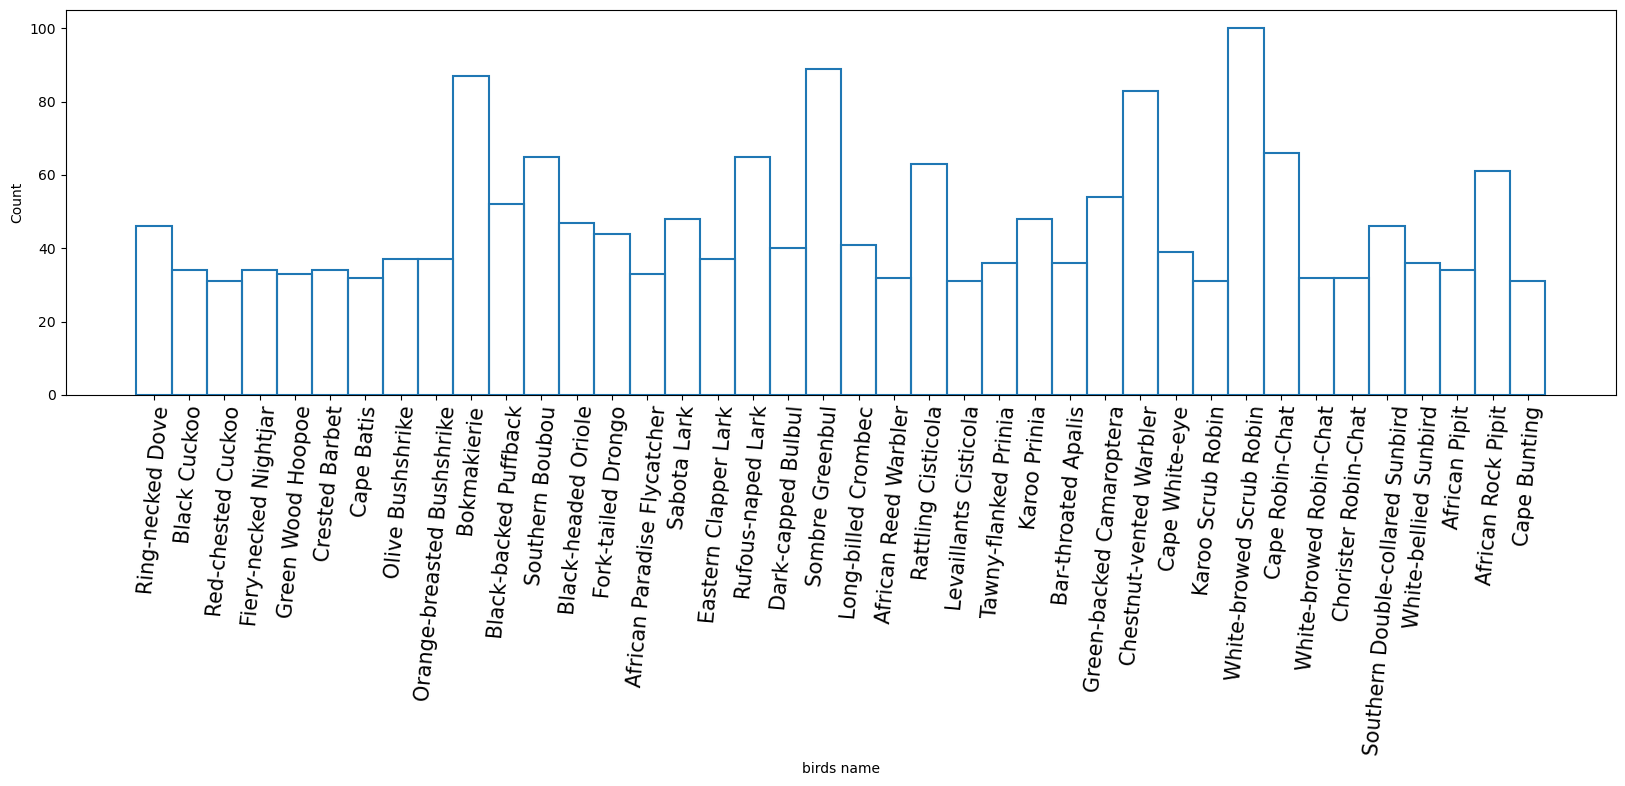

In [236]:
plt.figure(figsize=(20, 5))
sns.histplot(train['common_name'], fill=False)
plt.xticks(rotation=85, fontsize=15)
plt.xlabel('birds name')
plt.show()

#### Create Images Data from Audio Data - Train

In [237]:
# ids with issue
ids_with_issues = []


for idx, id in enumerate(tqdm(train['ID'])):
    # retrieve audio path
    audio_path = train.loc[idx, 'file_name']

    try:
        # convert audio to melspectogram
        melspectogram = audio_to_melspectogram(audio_path)

        # convert melspectogram to 3-channels image
        np_image = spec_to_mono_then_normalise(melspectogram)

        # save numpy to file (png)
        image = Image.fromarray(np_image)
        filename = os.path.join(os.getcwd(), 'train_images_5', 'spec_' + id + '.png')
        cv2.imwrite(filename, np.array(image))
    except Exception as e:
        print(e)
      

print(ids_with_issues)

 29%|██▉       | 535/1857 [00:24<01:07, 19.54it/s]C:\Users\Propietario\AppData\Local\Temp\ipykernel_27396\1396634533.py:34: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filepath)
c:\Users\Propietario\miniconda3\envs\datascience\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 29%|██▉       | 541/1857 [00:24<00:59, 22.16it/s]

 47%|████▋     | 879/1857 [00:43<00:43, 22.36it/s]

100%|██████████| 1857/1857 [01:34<00:00, 19.60it/s]

[]


#### Create Images Data from Audio Data - Test

In [238]:
# ids with isse
ids_with_issues = []

for idx, id in enumerate(tqdm(test['ID'])):
    # retrieve audio path
    audio_path = test.loc[idx, 'file_name']

    try:
        # convert audio to melspectogram
        melspectogram = audio_to_melspectogram(audio_path)

        # convert melspectogram to 3-channels image
        np_image = spec_to_mono_then_normalise(melspectogram)

        # save numpy to file (png)
        image = Image.fromarray(np_image)
        filename = os.path.join(os.getcwd(), 'test_images_5', 'spec_' + id + '.png')
        cv2.imwrite(filename, np.array(image))
    except Exception as e:
        print(e)
        # warnings.warn('There is an issue with an audio-data')
        # ids_with_issues.append(id)
        # continue

print(len(ids_with_issues))

100%|██████████| 911/911 [00:50<00:00, 18.11it/s]

0
